# AI in Medicine I - Practical 1: Brain Age Estimation

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI. We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

In [ ]:
!git branch
!git log

* main
commit 736d0b4cfe0d518d399cb6631bfa47df93595858 (HEAD -> main)
Author: Paul Schlack <paul.schlack@me.com>
Date:   Fri Oct 28 16:18:38 2022 +0200

    Initial Commit

commit de1b88e60929cb8c330fdbf2ee5557f12bea5453
Author: FeliMe <felix.meissen@gmail.com>
Date:   Thu Oct 27 12:17:31 2022 +0200

    Corrected MRI viewing directions

commit c4995088a1fd7bcd074a6a4c9ab89e441fffd5bd
Merge: 338de91 c06e606
Author: FeliMe <felix.meissen@gmail.com>
Date:   Thu Oct 27 12:11:00 2022 +0200

    Merge branch 'main' of github.com:compai-lab/aim-practical-1-brain-age-estimation into main

commit 338de9180dcc3c8949731512faf8a5855518c591
Author: FeliMe <felix.meissen@gmail.com>
Date:   Thu Oct 27 12:10:48 2022 +0200

    Implemented load_nii

commit c06e60646782b6dff8f5291f8a07585d5b3714de
Author: ci-ber <106509806+ci-ber@users.noreply.github.com>
Date:   Thu Oct 27 12:07:07 2022 +0200

    Update main.ipynb
    
    Correct brain orientation

commit 76498bfc45377580860f5d19b468662377d191fb
Aut

In [ ]:
# Only run this cell when in Google Colab
! git init
! git remote add origin https://github.com/panicPaul/aim-practical-1-brain-age-estimation.git
! git fetch
! git checkout -t origin/main


In [50]:
! git stash
! git pull origin main

No local changes to save
From https://github.com/panicPaul/aim-practical-1-brain-age-estimation
 * branch            main       -> FETCH_HEAD
Already up to date.


## Downloading the Data

In [5]:
! wget https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
! unzip brainage-data.zip
! wget https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
! unzip brainage-testdata.zip

--2022-11-05 10:52:43--  https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w9njau9t6rrheel/brainage-data.zip [following]
--2022-11-05 10:52:44--  https://www.dropbox.com/s/raw/w9njau9t6rrheel/brainage-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4a649d0d8578d1fb7aba4b5474.dl.dropboxusercontent.com/cd/0/inline/BwI9SNmSSYITAl9wCLTOO-zxfMkI1sMR92nSQdRGh8vdZ4RGRjSwcN1KIxQCzApw_fBIWNnLbVzHwNkei834hwu4upQRUof-3lRUhlREEfPSkYlzadXAlQr7xSRL4PMZS0-TJUb-zRjQUv7EMf_rpAvaOzW5jkkzMg7ngluuX9IiiA/file# [following]
--2022-11-05 10:52:44--  https://uc4a649d0d8578d1fb7aba4b5474.dl.dropboxusercontent.com/cd/0/inline/BwI9SNmSSYITAl9wCLTOO-zxfMkI1sMR92nSQdRGh8vdZ4RGRjSwcN1KIxQCzA

## Imports

In [6]:
from argparse import Namespace

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import Tensor
from tqdm import tqdm
import os
import glob

from data_utils import get_image_dataloaders, load_nii, load_segmentations
from plot_utils import plot_segmentations
from models import BrainAgeCNN
from utils import AvgMeter, mean_absolute_error, seed_everything, TensorboardLogger
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 500 for training, 47 for validation, and the rest for testing your final model.
The following cells provide helper functions to load the data and provide an overview and visualization of the statistics over the total population of the 652 subjects.

In [7]:
# Read the meta data using pandas
meta_data_all = pd.read_csv('./data/brain_age/meta/meta_data_all.csv')
meta_data_all.head()  # show the first five data entries


,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics

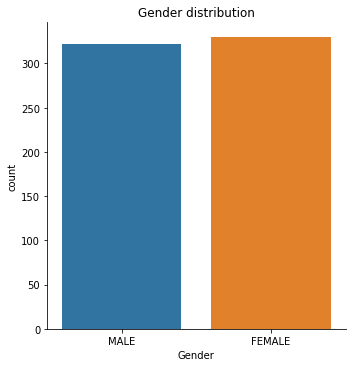

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


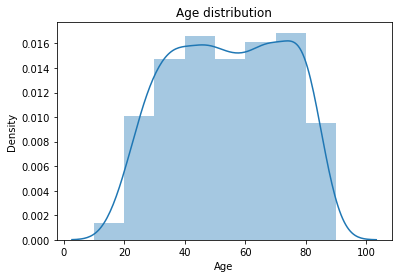

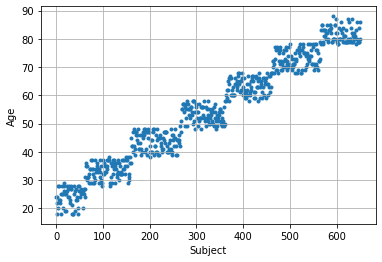

In [8]:
sns.catplot(x="gender_text", data=meta_data_all, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()
sns.distplot(meta_data_all['age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()
plt.scatter(range(len(meta_data_all['age'])), meta_data_all['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

## Imaging data
Let's check out the imaging data that is available for each subject.

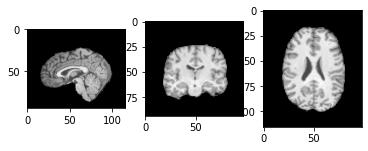

In [9]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3)
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Part A: Age prediction segmentation features

The first approach aims to regress the age of a subject from the volumes of brain tissues, including grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume might decrease.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task.

## Data loading and visualization

Let's first load all provided tissue segmentations and plot one of them.JJ

In [10]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|██████████| 652/652 [00:05<00:00, 114.61it/s]


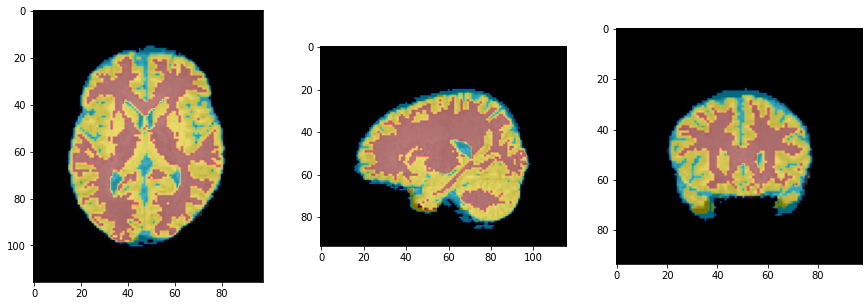

In [11]:
im = load_nii(f'data/brain_age/images/sub-{filenames[1]}_T1w_unbiased.nii.gz')
plot_segmentations(im, segmentations[1], i=40)

## Feature identification: TASK

Implement a function that calculates volume features given the three tissue volumes and the overal
brain volume (which can be calculated from the brain masks). You should use this function to
construct a big matrix X with a row for each subject and features across the columns.


In [12]:
df_labels = pd.read_csv('data/brain_age/meta/meta_data_all.csv')
labels = list(df_labels[df_labels['subject_id'].isin(filenames)].age)
assert list(df_labels[df_labels['subject_id'].isin(filenames)]['subject_id']) == filenames

In [17]:
y = np.array(labels)

# --------------------------- ADD YOUR CODE HERE ------------------------------
# Google Colabs memory constraints did not appreciate my code ...
#volume_1 = np.sum(np.where(segmentations[1: ] == 1, 1, 0), axis=-1)  
#volume_2 = np.sum(np.where(segmentations[1: ] == 2, 1, 0), axis=-1)
#volume_3 = np.sum(np.where(segmentations[1: ] == 3, 1, 0), axis=-1)
#volume_total = volume_1 + volume_2 + volume_3

volume_1 = np.array([np.sum(np.where(segmentation == 1, 1, 0)) for segmentation in segmentations])
volume_2 = np.array([np.sum(np.where(segmentation == 2, 1, 0)) for segmentation in segmentations])
volume_3 = np.array([np.sum(np.where(segmentation == 3, 1, 0)) for segmentation in segmentations])
volume_total = volume_1 + volume_2 + volume_3

X = np.vstack([volume_1 / volume_total, volume_2 / volume_total, volume_3 / volume_total, volume_total]).T
print(X.shape, y.shape)

(652, 4) (652,)


## Evaluation: TASK

Here, you should experiment with different regression methods and evaluate them using cross-validation. At least two different regression methods should be used. (Hint: sklearn has implementations of cross_validation and different regression models)

In [18]:
def cross_validation(model, X, y, folds=5):
    # --------------------------- ADD YOUR CODE HERE ------------------------------
    score = cross_val_score(model, X, y, cv=folds, scoring='neg_mean_absolute_error')
    # ----------------------------------- END -------------------------------------
    return score

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
# Feel free to import models from scipy here
# --------------------------- ADD YOUR CODE HERE ------------------------------

linear_model = LinearRegression() # todo implement another method
bayes_model = BayesianRidge()

linear_scores = cross_validation(linear_model, X, y)
bayes_scores = cross_validation(bayes_model, X, y)

print("Linear: %0.2f mae with a standard deviation of %0.2f" % (-linear_scores.mean(), linear_scores.std()))
print("Bayesian: %0.2f mae with a standard deviation of %0.2f" % (-bayes_scores.mean(), bayes_scores.std()))

# ----------------------------------- END -------------------------------------

Linear: 8.46 mae with a standard deviation of 2.06
Bayesian: 8.48 mae with a standard deviation of 2.08


## Part B: Age prediction from images using CNNs
Here we will use a convolutional neural network to directly predict a subject's age.
You will need to implement a CNN model in PyTorch that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output.

*Note:* You may want to set up a pre-processing pipeline that involves intensity normalisation

Familiarize yourself with the training and test-functions below. Note, how the model classes we use have a .train_step() function.

In [ ]:
def train(config, model, optimizer, train_loader, val_loader, writer):
    model.train()
    step = 0
    pbar = tqdm(total=config.val_freq,
                desc=f'Training')
    avg_loss = AvgMeter()

    while True:
        for x, y in train_loader:
            x = x.to(config.device)
            y = y.to(config.device)
            pbar.update(1)

            # Training step
            optimizer.zero_grad()
            loss = model.train_step(x, y)
            loss.backward()
            optimizer.step()

            avg_loss.add(loss.detach().item())

            # Increment step
            step += 1

            if step % config.log_freq == 0 and not step % config.val_freq == 0:
                train_loss = avg_loss.compute()
                writer.log({'train/loss': train_loss}, step=step)

            # Validate and log at validation frequency
            if step % config.val_freq == 0:
                # Reset avg_loss
                train_loss = avg_loss.compute()
                avg_loss = AvgMeter()

                # Get validation results
                val_results = validate(
                    model,
                    val_loader,
                    config,
                )

                # Print current performance
                print(f"Finished step {step} of {config.num_steps}. "
                      f"Train loss: {train_loss} - "
                      f"val loss: {val_results['val/loss']:.4f} - "
                      f"val MAE: {val_results['val/MAE']:.4f}")

                # Write to tensorboard
                writer.log(val_results, step=step)

                # Reset progress bar
                pbar = tqdm(total=config.val_freq, desc='Training')

            if step >= config.num_steps:
                print(f'\nFinished training after {step} steps\n')
                return model, step


def validate(model, val_loader, config, show_plot=False):
    model.eval()
    avg_val_loss = AvgMeter()
    preds = []
    targets = []
    for x, y in val_loader:
        x = x.to(config.device)
        y = y.to(config.device)

        with torch.no_grad():
            loss, pred = model.train_step(x, y, return_prediction=True)
        avg_val_loss.add(loss.item())
        preds.append(pred.cpu())
        targets.append(y.cpu())

    preds = torch.cat(preds)
    targets = torch.cat(targets)
    mae = mean_absolute_error(preds, targets)
    f = plot_results(preds, targets, show_plot)
    model.train()
    return {
        'val/loss': avg_val_loss.compute(),
        'val/MAE': mae,
        'val/MAE_plot': f
    }


def plot_results(preds: Tensor, targets: Tensor, show_plot: bool = False):
    # Compute the mean absolute error
    mae_test = mean_absolute_error(preds, targets)
    # Sort preds and targets to ascending targets
    sort_inds = targets.argsort()
    targets = targets[sort_inds].numpy()
    preds = preds[sort_inds].numpy()

    f = plt.figure()
    plt.plot(targets, targets, 'r.')
    plt.plot(targets, preds, '.')
    plt.plot(targets, targets + mae_test, 'gray')
    plt.plot(targets, targets - mae_test, 'gray')
    plt.suptitle('Mean Average Error')
    plt.xlabel('True Age')
    plt.ylabel('Age predicted')
    if show_plot:
        plt.show()
    return f


Let's create a config for our script. The given config only includes the bare minimum. You can and will extend it later to include own options.

In [ ]:
# Feel free to play around with the parameters here
# --------------------------- ADD YOUR CODE HERE ------------------------------
config = Namespace()
config.img_size = 96
config.batch_size = 16
config.num_workers = 4

config.log_dir = './logs'
config.val_freq = 50
config.log_freq = 10

config.seed = 0
config.device = 'cuda'

seed_everything(config.seed)
# ----------------------------------- END -------------------------------------

## Dataloading - TASK:

Finish the functions to generate the image dataloaders in ```data_utils.py```.
All tasks are indicated by 'ADD YOUR CODE HERE'

In [ ]:
# Load data
dataloaders = get_image_dataloaders(
    img_size=config.img_size,
    batch_size=config.batch_size,
    num_workers=config.num_workers
)

Loading data. This might take a while...
Loading train data...
Loading val data...
Loading test data...


## Model - TASK:

Create your model in ```models.py```. The basic logic is already given.

You need to complete the ```__init__``` function, the ```forward``` pass, and the loss-function.

In [46]:
from matplotlib.cbook import print_cycles
import torch
import torch.nn as nn

class test(nn.Module):
    """
    Squeeze And Excitation function
    """
    def __init__(self, n_channels) -> None:
        super().__init__()
        self.module = nn.ModuleList()
        self.module.append(nn.AdaptiveAvgPool3d((1, 1, 1))) #channelwise average pooling
        self.module.append(nn.Linear(n_channels, n_channels // 8))
        self.module.append(nn.ReLU())
        self.module.append(nn.Linear(n_channels // 8, n_channels))
        self.module.append(nn.Sigmoid())

    def forward(self, x):
        n, c, h, w, d = x.shape
        channel_weights = x
        for layer in self.module:
            channel_weights = layer(channel_weights)
        channel_weights = channel_weights.view(n, c, 1, 1, 1)
        return x * channel_weights.expand_as(x)

In [41]:
z = torch.zeros((2, 2, 4, 4, 4))
avg = nn.AdaptiveAvgPool3d(1)
avg(z)

tensor([[[[[0.]]],


         [[[0.]]]],



        [[[[0.]]],


         [[[0.]]]]])

In [47]:
from torchsummary import summary

test_model = test(1).to('cuda')
summary(test_model, (1, 96, 96, 96))

torch.Size([2, 1, 96, 96, 96])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool3d-1           [-1, 1, 1, 1, 1]               0
            Linear-2           [-1, 1, 1, 1, 0]               0
              ReLU-3           [-1, 1, 1, 1, 0]               0
            Linear-4           [-1, 1, 1, 1, 1]               1
           Sigmoid-5           [-1, 1, 1, 1, 1]               0
Total params: 1
Trainable params: 1
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.38
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 3.38
----------------------------------------------------------------


In [ ]:
# Init model
from torchsummary import summary
model = BrainAgeCNN(initial_channels=64, kernel_size=3).to('cpu')#.to(config.device)
summary(model, (2, 1, 96, 96, 96))

RuntimeError: ignored

## Config and Train: TASK

Finish the config and train your model. 

**Play around with different model architectures and hyperparameters until you find a model that reaches a satisfactory Mean Average Error of around 8.0**.

In [ ]:
# Feel free to add more hyperparameters here
# --------------------------- ADD YOUR CODE HERE ------------------------------
config.lr = 3e-4
config.betas = (0.9, 0.999)
config.num_steps = 5e10
# ----------------------------------- END -------------------------------------

In [ ]:
# Init optimizers
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas
)
# Init tensorboard
writer = TensorboardLogger(config.log_dir, config)
# Train
model, step = train(
    config=config,
    model=model,
    optimizer=optimizer,
    train_loader=dataloaders['train'],
    val_loader=dataloaders['val'],
    writer=writer
)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

## Tensorboard logging

Open Tensorboard to see your training performance.

In [ ]:
%tensorboard --logdir logs

## Final testing

Evaluate the final performance of your model. **This should only be done once with your final model!**

In [ ]:
# Test
test_results = validate(model, dataloaders['test'], config, show_plot=True)
test_results = {k.replace('val', 'test'): v for k, v in test_results.items()}
writer.log(test_results, step)
print(f'Test loss: {test_results["test/loss"]:.4f}')
print(f'Test MAE: {test_results["test/MAE"]:.4f}')

## Bonus

The goal of this bonus exercise is to track the carbon footprint of the brain age regression model you
implemented. You may use any tool you’d like. This exercise is purposely open, there is no material provided so you should experiment with the libraries that exist and the training procedure of your model.


In [ ]:
# --------------------------- ADD YOUR CODE HERE ------------------------------

# ----------------------------------- END -------------------------------------